In [4]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(123)

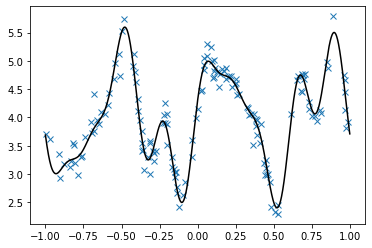

In [5]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

N = 150  # Number of training observations

X_train = rng.rand(N, 1) * 2 - 1  # X values
y_train = func(X_train) + 0.2 * rng.randn(N, 1)  # Noisy Y values
y_train = y_train + 4

X_test = np.linspace(-1, 1, 1000)[:, None] 
y_test = func(X_test)
y_test = y_test + 4

plt.plot(X_train, y_train, "x")
_ = plt.plot(X_test, y_test, c="k")

In [6]:
class Knots:

    def __init__(self, a, b, num_knots, order):

        # Parameters
        self.a = a
        self.b = b
        self.num_knots = num_knots
        self.order = order

    # Knot Patterns

    def uniform(self):
        left = np.repeat(self.a, self.order)
        interior = np.linspace(self.a, self.b, self.num_knots)
        right = np.repeat(self.b, self.order)
        return np.concatenate([left, interior, right])

    def quantile(self, X_train):
        left = np.repeat(self.a, self.order+1)
        right = np.repeat(self.b, self.order+1)

        interior = []

        for i in range(self.num_knots - 2 ):
            interior.append(np.quantile(X_train, (i+1)/(self.num_knots - 1 )))

        return np.concatenate([left, interior, right])


In [7]:
class Model:

    def __init__(self, a, b, order, num_basis, type_basis, type_knots, X_train):

        # Parameters
        self.a = a
        self.b = b
        self.order = order
        self.num_basis = num_basis
        self.num_knots = self.num_basis + 1 + self.order - (2* self.order)

        # Basis type
        if type_basis == 'B':
            self.type_basis = 'B'
        elif type_basis == 'F':
            self.type_basis = 'F'
        else:
            return ValueError('Not a recognisable basis')

        # Knots type
        if type_knots == 'U':
            self.knots = Knots(a=self.a, b=self.b, num_knots=self.num_knots, order=self.order).uniform()
        elif type_knots == 'Q':
            self.knots = Knots(a=self.a, b=self.b, num_knots=self.num_knots, order=self.order).quantile(X_train)
        else:
            return ValueError('Not a recognisable knot type')

        # Learnt parameters
        self.theta = None

    ## Generating basis functions

    def __B_basis_0(self, x):
        return np.where(np.all([self.knots[:-1] <=  x, x < self.knots[1:]],axis=0), 1.0, 0.0)

    def __B_basis(self, x, p):

        if p == 0:
            return self.__B_basis_0(x)
        
        else:
            basis_p_minus_1 = self.__B_basis(x, p - 1)

        term_1_num = x - self.knots[:-p]
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = self.knots[(p+1):] - x
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * basis_p_minus_1[:-1] + second_term * basis_p_minus_1[1:])


    def __fourier_basis(self, x):
        N = np.arange(self.num_basis/2)
        omega = (2 * np.pi * (N+1)) / (self.b - self.a)
        polynomial_basis = [1]
        for o in omega:
            polynomial_basis.append(np.cos(o*(x-self.a))[0])
            polynomial_basis.append(np.sin(o*(x-self.a))[0])
        return polynomial_basis

    ## Inference functions

    def __design_matrix(self, X):
        B = []

        if self.type_basis == 'B':
            for x in X:
                B.append(self.__B_basis(x, self.order))
            B = np.array(B).reshape([X.shape[0], -1])

        elif self.type_basis == 'F':
            for x in X:
                B.append(self.__fourier_basis(x))
            B = np.array(B).reshape([X.shape[0], self.num_basis+1])
        return B

    def __MLE(self, X_train, y_train):
        PHI = self.__design_matrix(X_train)
        theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(PHI),PHI)),np.transpose(PHI)),y_train)
        self.theta = np.array(theta).reshape([-1,1])
        return

    def __predict(self, X):
        PHI_test = self.__design_matrix(X)
        y_predict = np.matmul(PHI_test, self.theta)
        return y_predict

    def __MSE(self, X_test, y_test):
        y_predict = self.__predict(X_test)
        MSE = np.mean((y_test - y_predict) ** 2)
        print('MSE = ', MSE)

    def __plot(self, X_train, y_train, X_test, y_test):

        if self.type_basis == 'B':

            fig = plt.figure(figsize=(20,25))
            bfs = self.__design_matrix(X_test)
            y_predict = self.__predict(X_test)

            ax1 = plt.subplot(421)
            ax1.scatter(X_train, y_train, color='black', alpha=0.2)
            ax1.plot(X_test[:-1], y_predict[:-1], color='black')
            ax1.plot(X_test[:-1], y_test[:-1], color='blue', ls='--', alpha=0.8)
            if self.type_basis == 'B':
                for k in self.knots:
                    ax1.axvline(x=k, ymin=0.05, ymax=0.95, color='grey', ls='--', lw='1', label='axvline - % of full height', zorder=0, alpha=0.5)

            ax2 = plt.subplot(422)
            ax2.plot(X_test[:-1], y_predict[:-1], color='black')
            for i in range(self.num_basis):
                ax2.plot(X_test, bfs[:,i] * self.theta[i])
            if self.type_basis == 'B':
                for k in self.knots:
                    ax2.axvline(x=k, ymin=0.05, ymax=0.95, color='grey', ls='--', lw='1', label='axvline - % of full height', zorder=0, alpha=0.5)

            ax3 = plt.subplot(423)
            trial = np.random.randint(0,len(X_test))
            X_trial = X_test[trial,-1]
            y_trial = self.__predict(np.array(X_trial).reshape(1,1))[0][0]
            ax3.scatter(X_train, y_train, color='black', alpha=0.2)
            ax3.plot(X_test[:-1], y_predict[:-1], color='black')
            ax3.scatter(X_trial, y_trial, color='red', marker='o', zorder=10)
            ax3.axvline(x=X_trial, ymin=0.05, ymax=0.95, color='grey', ls='--', lw='1', label='axvline - % of full height', zorder=0, alpha=0.5)

            ax4 = plt.subplot(424)
            ax4.plot(X_test[:-1], y_predict[:-1], color='black')
            ax4.axvline(x=X_trial, ymin=0.05, ymax=0.95, color='grey', ls='--', lw='1', label='axvline - % of full height', zorder=0, alpha=0.5)
            for i in range(self.num_basis):
                if bfs[trial,i] == 0:
                    ax4.plot(X_test, bfs[:,i] * self.theta[i], alpha=0.2)
                else:
                    ax4.plot(X_test, bfs[:,i] * self.theta[i])
            ax4.scatter(X_trial, y_trial, color='red', marker='o', zorder=10)

        if self.type_basis == 'F':

            fig = plt.figure(figsize=(20,12))
            bfs = self.__design_matrix(X_test)
            y_predict = self.__predict(X_test)

            ax1 = plt.subplot(221)
            ax1.scatter(X_train, y_train, color='black', alpha=0.2)
            ax1.plot(X_test[:-1], y_predict[:-1], color='black')
            ax1.plot(X_test[:-1], y_test[:-1], color='blue', ls='--', alpha=0.8)
            if self.type_basis == 'B':
                for k in self.knots:
                    ax1.axvline(x=k, ymin=0.05, ymax=0.95, color='grey', ls='--', lw='1', label='axvline - % of full height', zorder=0, alpha=0.5)

            ax2 = plt.subplot(222)
            ax2.plot(X_test[:-1], y_predict[:-1], color='black')
            for i in range(self.num_basis):
                ax2.plot(X_test, bfs[:,i] * self.theta[i])
            if self.type_basis == 'B':
                for k in self.knots:
                    ax2.axvline(x=k, ymin=0.05, ymax=0.95, color='grey', ls='--', lw='1', label='axvline - % of full height', zorder=0, alpha=0.5)


            


    def inference(self, X_train, y_train, X_test, y_test):
        self.__MLE(X_train, y_train)
        self.__MSE(X_test, y_test)
        self.__plot(X_train, y_train, X_test, y_test)

MSE =  0.03249987168713717


array([-1.        , -1.        , -1.        , -1.        , -0.92592593,
       -0.85185185, -0.77777778, -0.7037037 , -0.62962963, -0.55555556,
       -0.48148148, -0.40740741, -0.33333333, -0.25925926, -0.18518519,
       -0.11111111, -0.03703704,  0.03703704,  0.11111111,  0.18518519,
        0.25925926,  0.33333333,  0.40740741,  0.48148148,  0.55555556,
        0.62962963,  0.7037037 ,  0.77777778,  0.85185185,  0.92592593,
        1.        ,  1.        ,  1.        ,  1.        ])

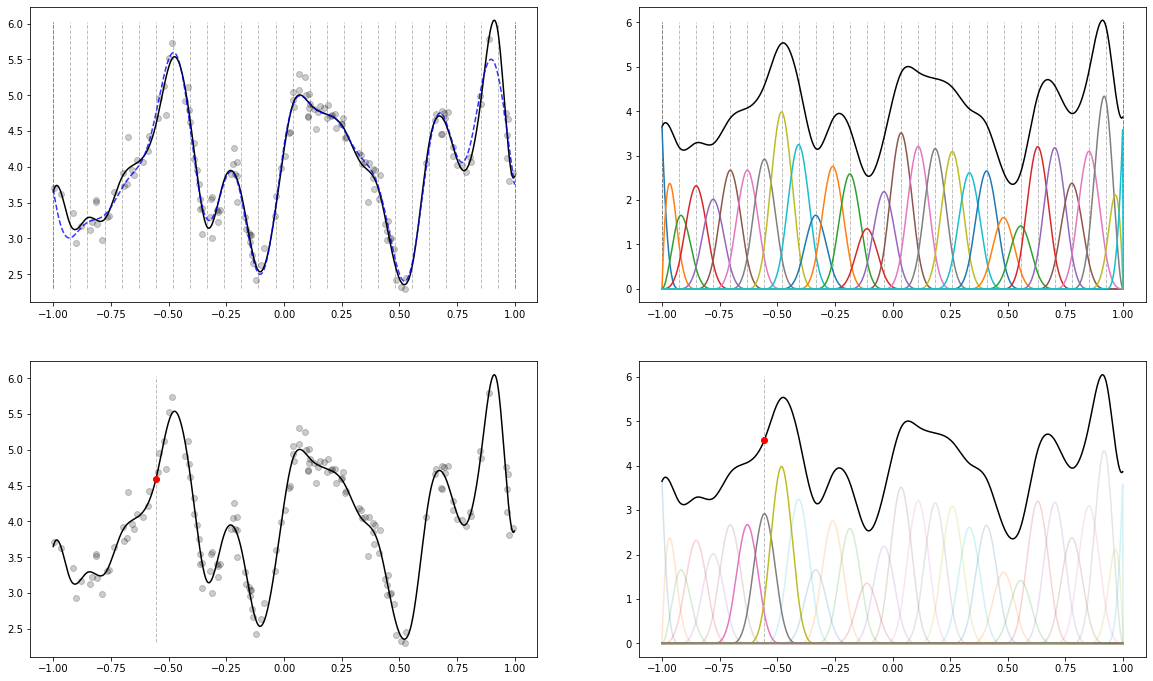

In [9]:
B = Model(a=-1, b=1, order=3, num_basis=30, type_basis='B', type_knots='U', X_train=X_train)
B.inference(X_train, y_train, X_test, y_test)
B.knots

MSE =  0.011644034151077808


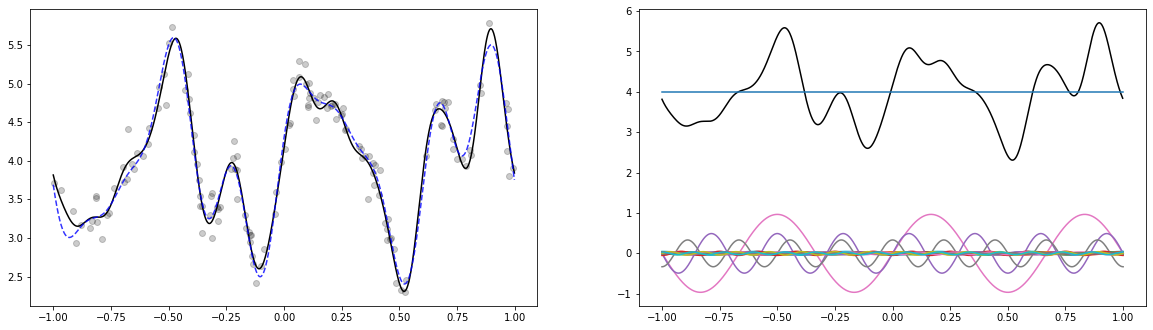

In [8]:
F = Model(a=-1, b=1, order=3, num_basis=30, type_basis='F', type_knots='U', X_train=X_train)
F.inference(X_train, y_train, X_test, y_test)

# Discontinuous Data

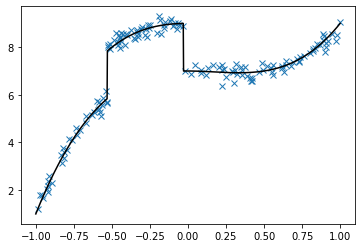

In [9]:
def func(X):
    ys = []
    for x in X:
        if x >= -0.53 and x <= -0.03:
            ys.append(4*x**3 - 2*x**2 + 1)
        else:
            ys.append(4*x**3 - 2*x**2 - 1)
    return ys

N = 150  # Number of training observations

X_train = rng.rand(N, 1) * 2 - 1  # X values
y_train = func(X_train) + 0.2 * rng.randn(N, 1)  # Noisy Y values
y_train = y_train
y_train = [y + 8 for y in y_train]

X_test = np.linspace(-1, 1, 1000)[:, None] 
y_test = func(X_test)
y_test = [y + 8 for y in y_test]

plt.plot(X_train, y_train, "x")
_ = plt.plot(X_test, y_test, c="k")

MSE =  0.11892226509749332


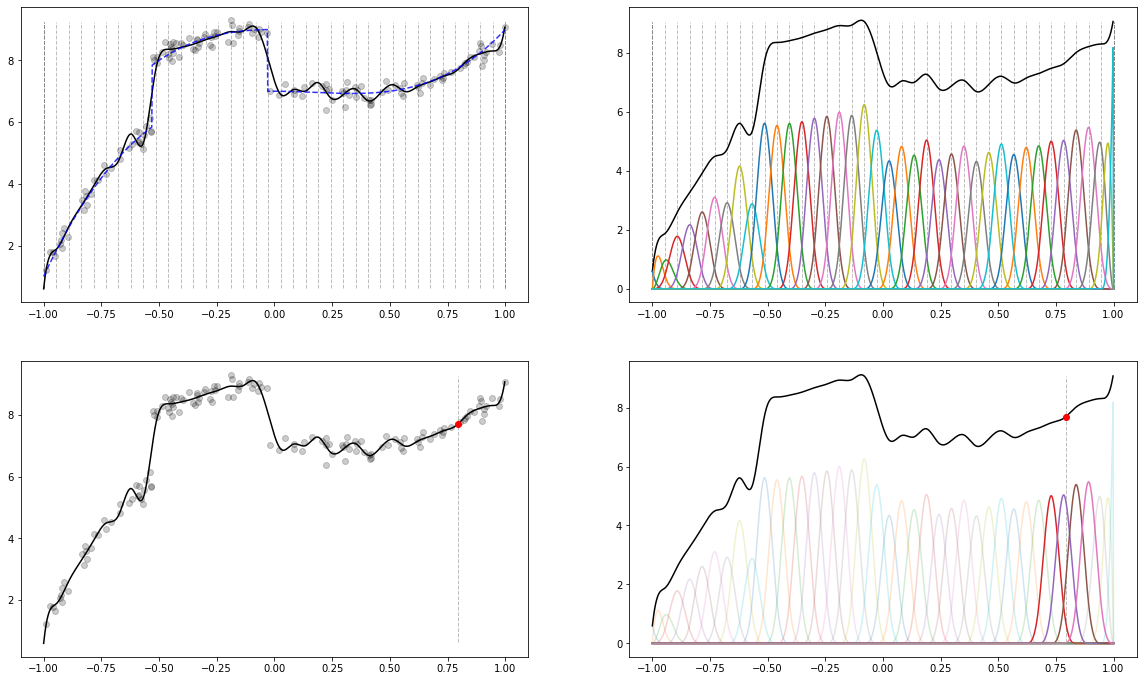

In [16]:
B = Model(a=-1, b=1, order=3, num_basis=40, type_basis='B', type_knots='U', X_train=X_train)
B.inference(X_train, y_train, X_test, y_test)

MSE =  0.2221832679847949


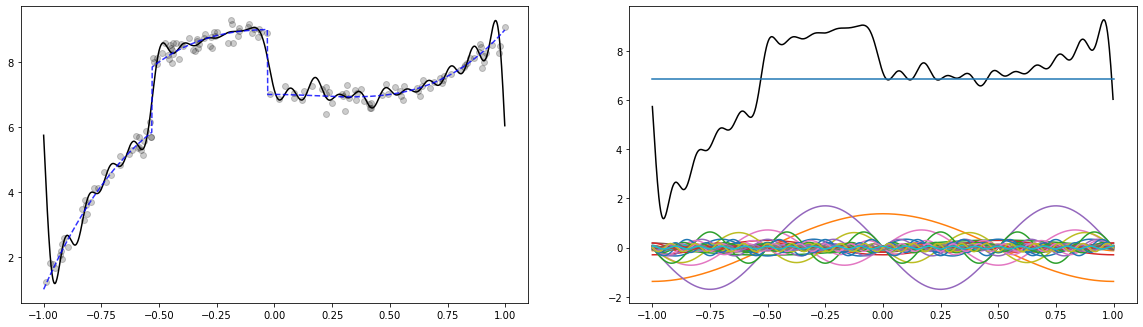

In [14]:
F = Model(a=-1, b=1, order=3, num_basis=40, type_basis='F', type_knots='U', X_train=X_train)
F.inference(X_train, y_train, X_test, y_test)